# Collaborative Filtering on MovieLens Dataset using PyTorch

In [25]:
import pandas as pd
import numpy as np

ratings = pd.read_csv('C:/Users/timsh/Desktop/data/ml-1m/ratings.dat',sep='::',
                      names=['userId','movieId','rating','timestamp'],engine='python')

In [26]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [27]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()
    
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

In [28]:
(n, m), (X, y), _ = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 6040 users, 3706 movies
Dataset shape: (1000209, 2)
Target shape: (1000209,)


In [29]:
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [30]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [31]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler


class EmbeddingNet(nn.Module):

    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [32]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

In [33]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [34]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

In [35]:
import math
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [36]:
minmax = ratings.rating.min().astype(float), ratings.rating.max().astype(float)
minmax

(1.0, 5.0)

In [37]:
from picklable_itertools import zip_longest

net = EmbeddingNet(
    n_users=n, n_movies=m, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [38]:
import copy

lr = 1e-3
wd = 1e-5
bs = 2000
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
                loss = criterion(outputs, y_batch)
                
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

C:\Users\timsh\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss improvement on epoch: 1
[001/100] train: 0.8879 - val: 0.8220
loss improvement on epoch: 2
[002/100] train: 0.7962 - val: 0.8062
loss improvement on epoch: 3
[003/100] train: 0.7988 - val: 0.7976
loss improvement on epoch: 4
[004/100] train: 0.7563 - val: 0.7872
loss improvement on epoch: 5
[005/100] train: 0.7649 - val: 0.7870
loss improvement on epoch: 6
[006/100] train: 0.7269 - val: 0.7847
[007/100] train: 0.7387 - val: 0.7853
[008/100] train: 0.6931 - val: 0.7883
loss improvement on epoch: 9
[009/100] train: 0.7057 - val: 0.7824
[010/100] train: 0.6507 - val: 0.7963
[011/100] train: 0.6683 - val: 0.7897
[012/100] train: 0.6125 - val: 0.8059
[013/100] train: 0.6340 - val: 0.7984
[014/100] train: 0.5809 - val: 0.8148
[015/100] train: 0.6053 - val: 0.8096
[016/100] train: 0.5563 - val: 0.8244
[017/100] train: 0.5820 - val: 0.8167
[018/100] train: 0.5369 - val: 0.8313
[019/100] train: 0.5633 - val: 0.8291
early stopping after epoch 019


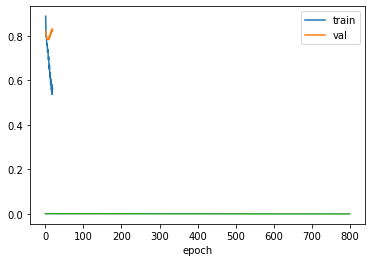

In [39]:
import matplotlib.pyplot as plt

ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')
_ = plt.plot(lr_history[:2*iterations_per_epoch])

In [40]:
net.load_state_dict(best_weights)

groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.8844


In [41]:
import pickle

with open('best.weights', 'wb') as file:
    pickle.dump(best_weights, file)

In [42]:
from sklearn.decomposition import PCA

with open('best.weights', 'rb') as file:
    best_weights = pickle.load(file)
net.load_state_dict(best_weights)

def to_numpy(tensor):
    return tensor.cpu().numpy()

In [43]:
_, _, (user_id_map, movie_id_map) = create_dataset(ratings)
embed_to_original = {v: k for k, v in movie_id_map.items()}
popular_movies = ratings.groupby('movieId').movieId.count().sort_values(ascending=False).values[:1000]

In [44]:
embed = to_numpy(net.m.weight.data)
pca = PCA(n_components=5)
components = pca.fit(embed[popular_movies].T).components_
components.shape

(5, 1000)

In [45]:
movies = pd.read_csv('C:/Users/timsh/Desktop/data/ml-1m/movies.dat',sep='::',
                      names=['movieId','title','genres'],engine='python')

In [46]:
components_df = pd.DataFrame(components.T, columns=[f'fc{i}' for i in range(pca.n_components_)])
movie_ids = [embed_to_original[idx] for idx in components_df.index]
meta = movies.set_index('movieId')
components_df['movie_id'] = movie_ids
components_df['title'] = meta.loc[movie_ids].title.values
components_df['genres'] = meta.loc[movie_ids].genres.values

components_df.sample(4)

,fc0,fc1,fc2,fc3,fc4,movie_id,title,genres
224,-0.007304,0.010285,-0.004619,-0.036791,-0.002754,1535,Love! Valour! Compassion! (1997),Drama|Romance
241,0.097454,-0.005036,0.052626,-0.029056,0.025224,3799,Pok閙on the Movie 2000 (2000),Animation|Children's
102,0.002055,-0.017397,-0.044099,0.062608,0.000783,982,Picnic (1955),Drama
714,-0.015047,0.030526,0.006186,0.009004,-0.059221,1200,Aliens (1986),Action|Sci-Fi|Thriller|War


In [49]:
from textwrap3 import wrap

def plot_components(components, component, ascending=False):
    fig, ax = plt.subplots(figsize=(18, 12))
    
    subset = components.sort_values(by=component, ascending=ascending).iloc[:12]
    columns = components_df.columns
    features = columns[columns.str.startswith('fc')].tolist()
    
    fc = subset[features]
    titles = ['\n'.join(wrap(t, width=10)) for t in subset.title]
    genres = subset.genres.str.replace('|', '\n')
    labels = [f'{t}\n\n{g}' for t, g in zip(titles, genres)]
    
    fc.plot(ax=ax, kind='bar')
    y_ticks = [f'{t:2.2f}' for t in ax.get_yticks()]
    ax.set_xticklabels(labels, rotation=0, fontsize=14)
    ax.set_yticklabels(y_ticks, fontsize=14)
    ax.legend(loc='best', fontsize=14)
    
    plot_title = f"Movies with {['highest', 'lowest'][ascending]} '{component}' component values" 
    ax.set_title(plot_title, fontsize=20)

C:\Users\timsh\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 38297 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\timsh\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 38297 missing from current font.
  font.set_text(s, 0, flags=flags)


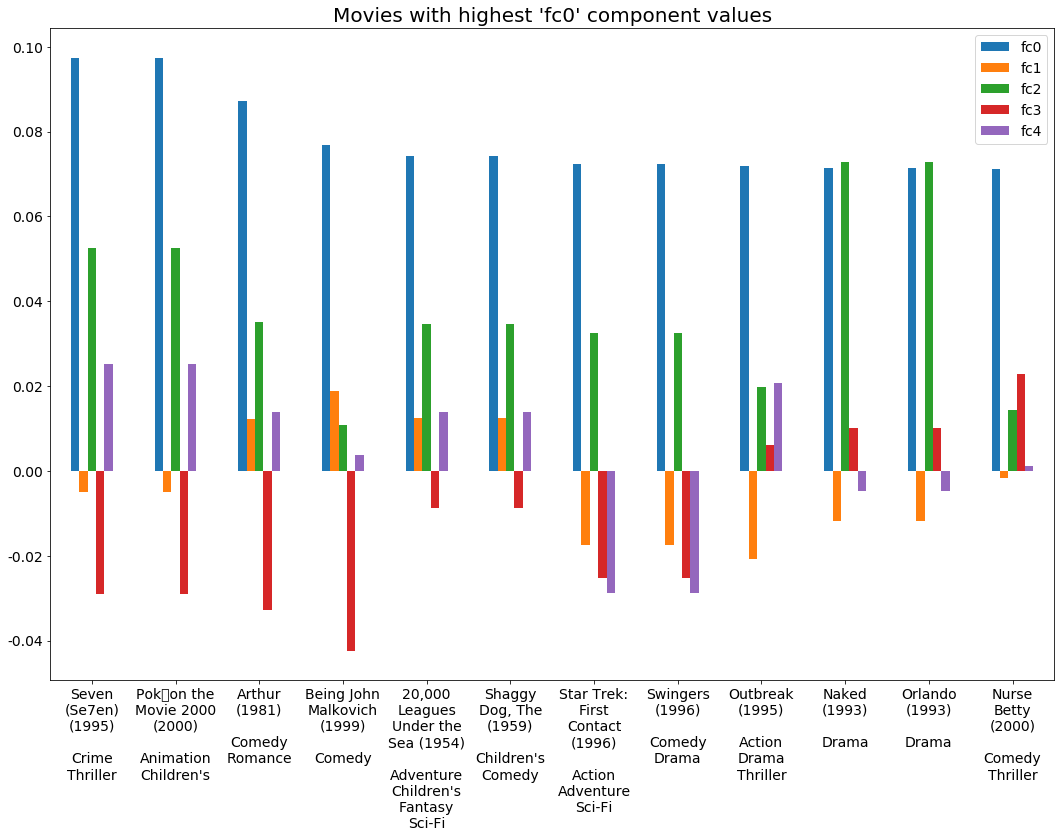

In [50]:
plot_components(components_df, 'fc0', ascending=False)

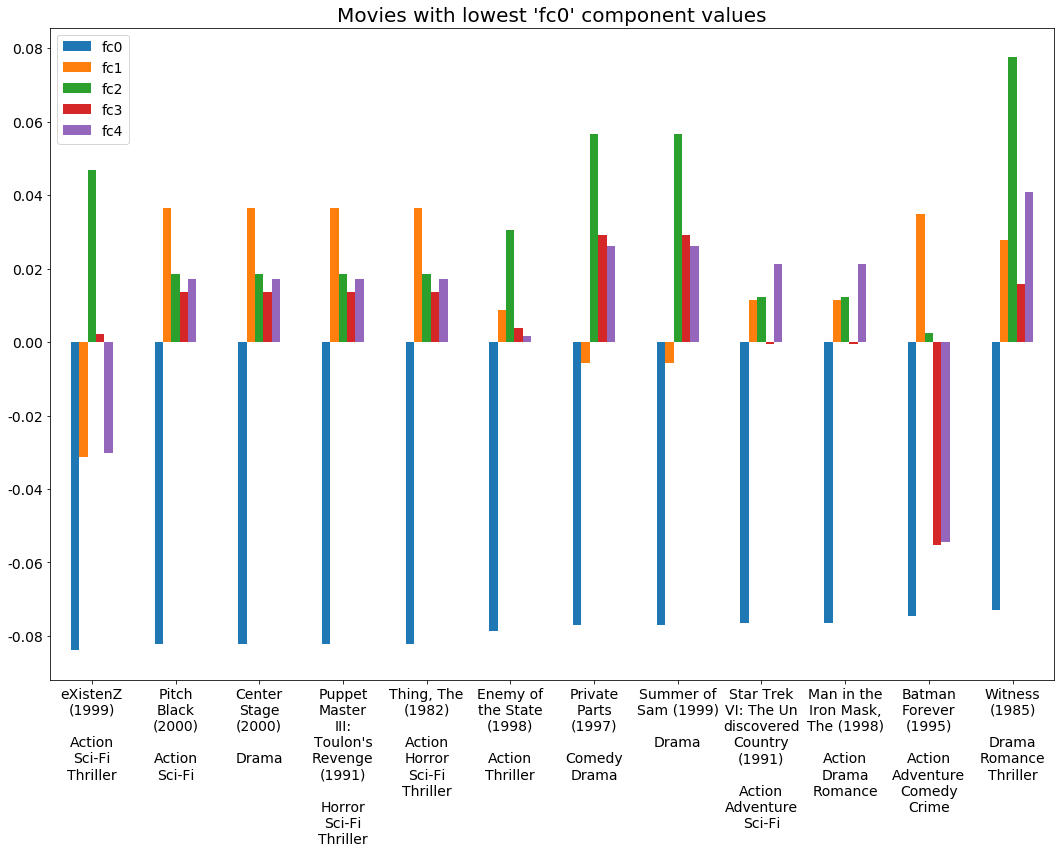

In [51]:
plot_components(components_df, 'fc0', ascending=True)